# Siamese Networks
For all of the classification problems we have dealt with so far, we have had the luxury of having a **large** amount of training data.  Large data samples tend to be necessary in order to achieve high classification accuracy.

But what if our training sample sizes are limited, and yet we still need to achieve high classifier accuracy?  One possibility is to use **data augmentation** - essentially using your training data to **create** more semi-independent training samples.   For image classification, Keras comes with a variety of tools for just that circumstance.

However, there are other circumstances where this approach is not practical.  For example, consider the case of the iPhoneX Facial Recognition algorithm.  If we were to approach this as a standard classification algorithm, we could do the following:
1.   Get a large number of images containing background faces.
2.   Get a large number of images of the iPhone user as our signal.
3.   Train the network.
The obvious problem with this is steps 2 and 3: getting a large enough sample of signal images as well as training the network (which presumably would have to be done offline and not on the iPhone).  In this case, each user would need a personally trained algorithm.  This approach clar **does not scale**.

There is a different approach utilizing **Siamese Networks** which this workbook describes.  To see how this works, let's introduce another data set, called the **Omniglot** dataset.

Much of the discussion in this workbook is motivated by the work from this [article](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) as well as this [paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).


# The Omniglot Dataset
This is a collection which is superfically similar to the MNIST dataset.   In the MNIST dataset:
*  We had a collection of 10 hand drawn digits from 0 through 9.
*  Each digit in the training set had approximately 6000 hand drawn examples, each drawn by a different person.   The testing set had about 1000 of each digit.
*  The images were in gray scale (1 channel) with a pixel resolution of 28x28.

Omniglot is quite different.  From the paper: "The Omniglot data set was collected by Brenden Lake and his collaborators at MIT via Amazon’s Mechanical Turk to
produce a standard benchmark for learning from few examples in the handwritten character recognition domain (Lake et al., 2011).1 Omniglot contains examples from 50 alphabets ranging from well-established international languages like Latin and Korean to lesser known local dialects. It also includes some fictitious character sets such as Aurek-Besh and Klingon."

For the Omniglot dataset:
*  We have a collection of 1623 hand drawn characters from 50 different alphabets. 
*  Each character has just 20 examples, each drawn by a different person.   There is no formal *test* set.   For our studies, we will arbitrarily split the data into 964 training characters  (20 of each) and 659 validation characters  (20 of each).
*  Each image is a gray scale image of resolution 105x105.

Lets read this dataset in, and explore it a bit.

In [1]:
import pickle
X_train,lang_train = pickle.load(open("/fs/scratch/PAS1495/physics6820/siamese/data/train.pickle","rb"))
X_val,lang_val = pickle.load(open("/fs/scratch/PAS1495/physics6820/siamese/data/val.pickle","rb"))

X_train = X_train / 255.0
X_val = X_val / 255.0
#
# Create lookup tables which take us from character index to language
train_lang_lookup = {}
for lang in lang_train:
    val_min,val_max = lang_train[lang]
    for val in range(val_min,val_max+1):
        train_lang_lookup[val] = lang#
# Create lookup tables which take us from character index to language
val_lang_lookup = {}
for lang in lang_val:
    val_min,val_max = lang_val[lang]
    for val in range(val_min,val_max+1):
        val_lang_lookup[val] = lang

#
print("Training shapes:    ",X_train.shape)
print("Training languages: ",lang_train)
#
print()
print("Validation shapes:    ",X_val.shape)
print("Validation languages:  ",lang_val)


Training shapes:     (964, 20, 105, 105)
Training languages:  {'Latin': [0, 25], 'Futurama': [26, 51], 'Cyrillic': [52, 84], 'Syriac_(Estrangelo)': [85, 107], 'Armenian': [108, 148], 'Greek': [149, 172], 'Hebrew': [173, 194], 'Sanskrit': [195, 236], 'Braille': [237, 262], 'Balinese': [263, 286], 'Japanese_(katakana)': [287, 333], 'Arcadian': [334, 359], 'Alphabet_of_the_Magi': [360, 379], 'Tifinagh': [380, 434], 'Asomtavruli_(Georgian)': [435, 474], 'Anglo-Saxon_Futhorc': [475, 503], 'Tagalog': [504, 520], 'Mkhedruli_(Georgian)': [521, 561], 'Gujarati': [562, 609], 'Bengali': [610, 655], 'Grantha': [656, 698], 'Burmese_(Myanmar)': [699, 732], 'Malay_(Jawi_-_Arabic)': [733, 772], 'Blackfoot_(Canadian_Aboriginal_Syllabics)': [773, 786], 'Japanese_(hiragana)': [787, 838], 'Ojibwe_(Canadian_Aboriginal_Syllabics)': [839, 852], 'Early_Aramaic': [853, 874], 'Inuktitut_(Canadian_Aboriginal_Syllabics)': [875, 890], 'Korean': [891, 930], 'N_Ko': [931, 963]}

Validation shapes:     (659, 20, 105,

# Visualizing the Characters
Lets look at our validation set.   The images are stored in the numpy arrays **X_train** and  **X_val**.   The shape of the validation array is: (659, 20, 105, 105).  
*  The first index is tells us which **character** we are viewing, and goes from 0-658.
*  The second index tells us which **example of that character** we are viewing, and goes from 0-19.
*  The third and fourth indices are the pixel positions of our character. 

The script below chooses the first 10 characters from 10 different langauages.   Play with the offset and *use_val* to look at different languages and characters.

Validation Language: Gurmukhi


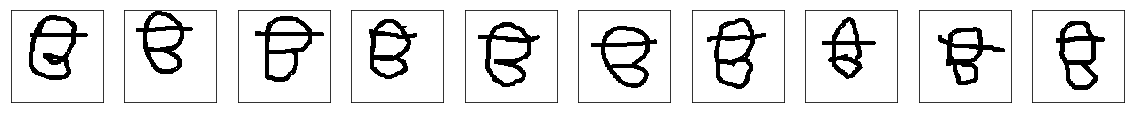

Validation Language: Atemayar_Qelisayer


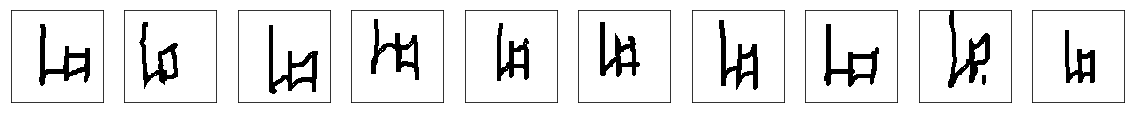

Validation Language: Glagolitic


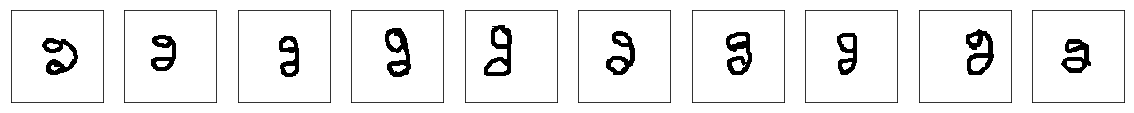

Validation Language: Kannada


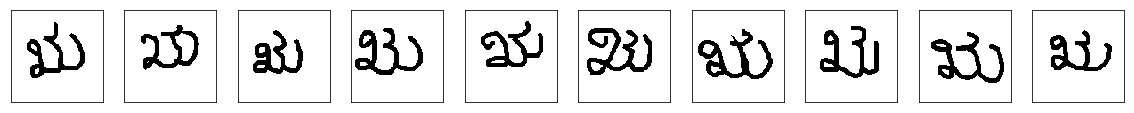

Validation Language: Keble


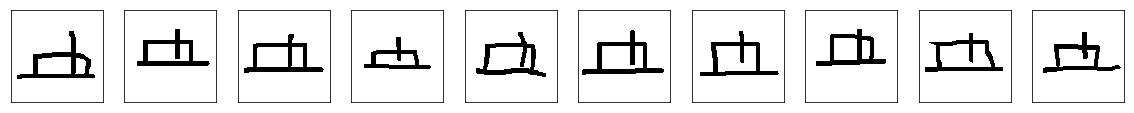

Validation Language: Oriya


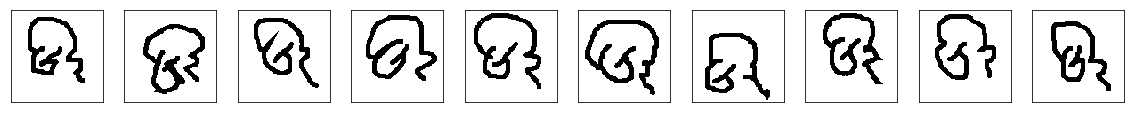

Validation Language: Old_Church_Slavonic_(Cyrillic)


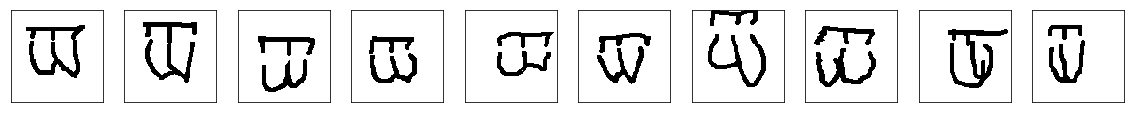

Validation Language: Syriac_(Serto)


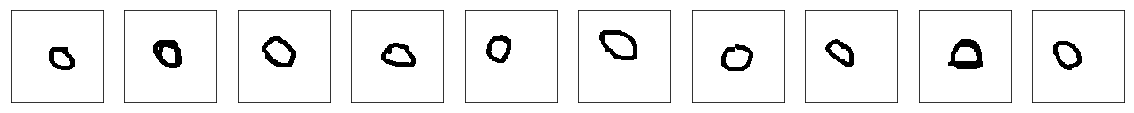

Validation Language: Tibetan


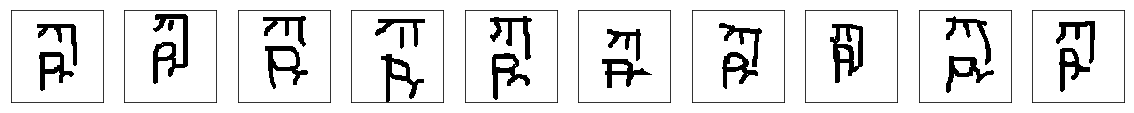

Validation Language: Aurek-Besh


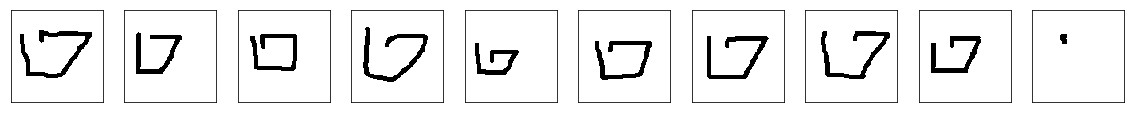

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
nrows = 10 # how many classes
n = 10  # how many examples of each class we will display
use_val = val  # switch between validation and training
offset = 65  # should not be larger than about 659/10 for val and 964/10 for training
if use_val: #use X_val, 659 validation characters (20 of each)
    if offset*(nrows-1)>X_val.shape[0]:
        offset = X_train.shape[0]//nrows
else: #use X_train, 964 validation characters (20 of each)
    if offset*(nrows-1)>X_train.shape[0]:
        offset = X_train.shape[0]//nrows

for row in range(nrows):
    if use_val:
        print("Validation Language:",val_lang_lookup[row*offset])
    else:
        print("Training Language:",train_lang_lookup[row*offset])
    plt.figure(figsize=(20, 20))
    for i in range(n):
        ax = plt.subplot(nrows, n, i + 1 +(row*n))
        if use_val:
            plt.imshow(X_val[row*offset,i,:,:])
        else:
            plt.imshow(X_train[row*offset,i,:,:])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Classifying a Single Character
If you keep the defaults above (specifically *val_true=True*) you should see the printout befiore the first line as: "Validation Language: Gurmukhi", and the resulting character looks almost like a Latin B with an additional horizontal line through the upper loop.

Below we plot a **different** hand drawn version of that same character:

(105, 105)


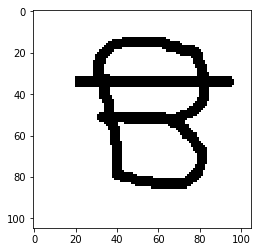

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
img = X_val[0,15,:,:]
print(img.shape)
plt.imshow(img, cmap='gray')
plt.show()

# N-way one shot learning
Our goal is to associate the above character with the appropriate **character** set it came from (the character - not the alphabet).   We will do this assuming that our network has **not** been trained on this specific character ahead of time.

Given the nature of this problem, we will use a different metric to assess our performance:
**N-way one shot learning**.   The basic idea is this:
*  We randomly select a test character from our dataset.
*  We select $N$ other samples to compare our test character to, **one of which** is a **different** version of the **same** test character, while the N-1 other characters are all different characters, each from a different character set.
*  We use our model to calculate a **similarity** score, and use this score to choose the best matching character set.  If the chosen character set is the one our test character was drawn from, then our model was correct, otherwise it was wrong.  For each correct case we increment N_correct.
*  We do this for many trials N_trials, and our accuracy is then (N_correct/N_trials).

A figure showing 9-way one shot learning is shown here (from [this link]):(https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d):
![9-way one shot learning](figs/n_way_9.jpeg)


A figure showing 16-way one shot learning is shown here (from [this link]):(https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d):
![9-way one shot learning](figs/n_way_16.jpeg)

# Baseline Model: Guessing
If we use the N-way one shot learning method to assess performance, it would be nice to have a simple baseline model to compare against.   The simplest model is guessing:
*  For N=2, the expected performance is 1/2 or 50%
*  For N=9, the expected performance is 1/9 or 11.1%
*  For N=16, the expected performance is 1/16 or 6.25%
We should be able to do better than this!


# Baseline Model: Cosine Similarity
This is actually a single-nearest-neighbor model, where the distance metric is the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).  The idea is this:
* We think of each of our 105x105 images as 11025(=105x105) dimensional vector.
* We calculate the "cosine" between each pair of vectors.
* The pair with the largest similarity gives us the matching character set.

The **nearest_neighbor_cosine** method below implements this calculation.

In [4]:

def nearest_neighbour_cosine(v1,v2,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    cossim = np.zeros_like(targets)
    for i in range(len(targets)):
        cossim[i] = np.sqrt(np.sum(v1[i]*v2[i])/(np.sum(v1[i]**2)*np.sum(v2[i]**2)))
    if np.argmax(cossim) == np.argmax(targets):
        return 1
    return 0


def nearest_neighbour_L2dist(v1,v2,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt((v1[i]- v2[i])**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

# N-way testing using cosine similarity
The code below implements N-way testing for N=5,10,15,20, and compares guessing with the cosine similarity model.  This second model does much better than guessing, but still only achieves about 25% for N=20.  Can we do better?

In [5]:
import random
import numpy as np
n_classes, n_examples, w, h = X_val.shape
letters = list(range(n_classes))
examples = list(range(n_examples))
#
# Loop over different "N" values
x = []
accuracy_nn = []
accuracy_guess = []
for N in [5,10,15,20]:
#
# Loop over trials
    number_correct = 0
    number_trials = 0
    for trials in range(5000):
#
# Each trial shuffle our letters and classes 
        random.shuffle(letters)
        random.shuffle(examples)
    #print(examples)
#
# Get our support indices
        support_letters_class_indices = letters[0:N]
        support_letters_example_indices = examples[0:N]
#
# Get the letter to test
        test_letter_class_index = letters[0]
        test_letter_example_index = examples[0]
#
# Now get another example (but different) of the test letter
        test_letter_class_index_other = letters[0]
        test_letter_example_index_other = examples[1]
#
# The first letter in our support sample is the correct class
        support_letters_class_indices[0] = test_letter_class_index_other
        support_letters_example_indices[0] = test_letter_example_index_other
        targets = np.zeros((N,))
        targets[0] = 1
#
# Now form our images
        test_images = np.asarray([X_val[test_letter_class_index,test_letter_example_index,:,:]]*N)
        test_images = test_images.reshape(N, w, h,1)
        support_images = X_val[support_letters_class_indices,support_letters_example_indices,:,:]
        support_images = support_images.reshape(N, w, h,1)
#
# Now get the cosine
        res = nearest_neighbour_cosine(test_images,support_images,targets)
        number_trials += 1
        if res == 1:
            number_correct += 1
        #print("res ",res)
    accuracy = round(float(number_correct)/float(number_trials),2)
    print("N:",N,"Number trials:",number_trials,"; number correct:",number_correct,'; accuracy:',accuracy)
    x.append(N)
    accuracy_nn.append(accuracy)
    accuracy_guess.append(1.0/N)
    
    

N: 5 Number trials: 5000 ; number correct: 2233 ; accuracy: 0.45
N: 10 Number trials: 5000 ; number correct: 1559 ; accuracy: 0.31
N: 15 Number trials: 5000 ; number correct: 1425 ; accuracy: 0.28
N: 20 Number trials: 5000 ; number correct: 1157 ; accuracy: 0.23


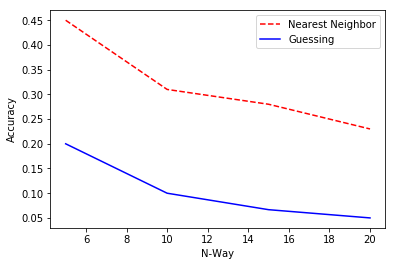

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# Visualize loss history
plt.plot(x, accuracy_nn, 'r--')
plt.plot(x, accuracy_guess, 'b-')
plt.legend(['Nearest Neighbor', 'Guessing'])
plt.xlabel('N-Way')
plt.ylabel('Accuracy')
plt.show();


# Siamese Networks: Implementation
Before we begin, let's recall the basic problem:
*  We want a network that can be given a few different images of the same obejct.
*  It is then given another image: either of the same object (the signal) or a different object (the background).
*  If the new image is simply a different version of our **signal** object, then we want it to output 1, while if it is any other object, we want it to output 0.
*  We need to be able to do this **without** retraining the network!

The solution to this problem is to train a network to learn the differences between two images, minimizing the loss if the images are very similar, while maximizing the loss if the images are different.  A cartoon of the basic structure is shown below:
![siamese network cartoon](figs/siamese_net.jpeg)

During training, two images are fed to the network.  The network is a dual-head network, composed of two **identical** CNNs (who share exactly the same weights).   This CNN learns the feature vectors which represent the images.  In our case, the learned feature vector is of size 4096.  The output of these two CNNs are fed into a **Lamba** layer, which in Keras can be used to take the absolute difference between two other Keras layers.   This difference is then fed into a final single outout sigmoid layer.

The actual network implemented in the paper is shown here:

![siamese network actual](figs/actual_siamese_net_paper.png)
This paper is very readable!  You can find it [here](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).

The next code block shows the implementation details for the siamese network.


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers import Lambda, Flatten, Dense, Input
from keras.initializers import glorot_uniform, RandomNormal

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras import layers
import numpy as np


def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=RandomNormal(mean=0.0, stddev=0.01),
                   kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.01),
                     bias_initializer=RandomNormal(mean=0.5, stddev=0.01), 
                     kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.01),
                     bias_initializer=RandomNormal(mean=0.5, stddev=0.01), 
                     kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.01),
                     bias_initializer=RandomNormal(mean=0.5, stddev=0.01), 
                     kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=RandomNormal(mean=0.0, stddev=0.01),
                    bias_initializer=RandomNormal(mean=0.5, stddev=0.01)))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=RandomNormal(mean=0.5, stddev=0.01))(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net


# Make the model
The code below makes the model and compiles it.

In [ ]:
model = get_siamese_model((105, 105, 1))
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)
model.summary()

# Generating Samples for Training
This method actually chooses a batch of pairs of training data.   This is a little tricky since true samples need to be **different** examples from the **same** character (or letter), while background samples need to be examples from **different** characters.

Half of the pairs are different examples from the same class, while the other half are examples from different classes.  Also, it is importand that we coherently shuffle things at the end of this method, so that during training the network is provided with samples that are randomly from the same set or not.

In [ ]:
import random
import numpy as np
from sklearn.utils import shuffle

def get_batch(batch_size,use_test_data=False):
#
# For each batch shuffle
    if use_test_data:
        n_classes, n_examples, w, h = X_val.shape #n_examples are at most 20, since we only have 20 versions
    else:
        n_classes, n_examples, w, h = X_train.shape
    letters = list(range(n_classes)) #list() turns an iterable into a list. In this case, it returns integers 0~ n_classes
    examples = list(range(n_examples))
#
# Each trial shuffle our letters and classes 
    random.shuffle(letters)
    random.shuffle(examples)
    targets = np.zeros((batch_size,))
    test_images = np.zeros((batch_size,w, h))
    support_images = np.zeros((batch_size,w, h))
#
# Make sure the batch size is < half the classes
    if batch_size < n_classes//2:
        half_batch = batch_size//2
#
# Get the indices for the 1st half - which are pairs from same class
        test_letter_class_indices = letters[0:half_batch]
        test_letter_example_index = examples[0]
        support_letters_class_indices = letters[0:half_batch]
        support_letters_example_index = examples[1]
#
# Are we generating these batches using validation or training data?
        if use_test_data:
            test_images[0:half_batch,:,:] = X_val[test_letter_class_indices,test_letter_example_index,:,:]
            support_images[0:half_batch,:,:] = X_val[support_letters_class_indices,support_letters_example_index,:,:]
        else:
            test_images[0:half_batch,:,:] = X_train[test_letter_class_indices,test_letter_example_index,:,:]
            support_images[0:half_batch,:,:] = X_train[support_letters_class_indices,support_letters_example_index,:,:]
        targets[0:half_batch] = 1
#
# Get the indices for the 2nd half - which are pairs from different classes
        test_letter_class_indices = letters[half_batch:batch_size]
        test_letter_example_index = examples[0]
        support_letters_class_indices = letters[batch_size:batch_size+half_batch]
        support_letters_example_index = examples[1]
        
        if use_test_data:
            test_images[half_batch:batch_size,:,:] = X_val[test_letter_class_indices,test_letter_example_index,:,:]
            support_images[half_batch:batch_size,:,:] = X_val[support_letters_class_indices,support_letters_example_index,:,:]
        else:
            test_images[half_batch:batch_size,:,:] = X_train[test_letter_class_indices,test_letter_example_index,:,:]
            support_images[half_batch:batch_size,:,:] = X_train[support_letters_class_indices,support_letters_example_index,:,:]
        targets[half_batch:batch_size] = 0
#
# Reshape
        test_images = test_images.reshape(batch_size, w, h,1)
        support_images = support_images.reshape(batch_size, w, h,1)

#
# Now shuffle coherently
    targets, test_images, support_images = shuffle(targets, test_images, support_images)
    pairs = [test_images, support_images]

    return pairs, targets


# Generating samples for N-way testing
This method generates "N" pairs of data for N-way testing.   Since this is not data for training, we do not need to shuffle it.   The samples **are** randomly selected, but this is done by shuffling the order of the classes (which are called **letters** below) as well as the order of examples of each letter.  We can then pick these in order. 

We can pick from the training set (to measure the training performance) or from the validation set (to measure performance on unseen data).

Remember that for N-way testing, only 1 of the N pairs contains a matching character pair, whie the other N-1 are pairs contain one character which is the same as the first pair, and one character which is different.

In [ ]:
def make_oneshot(N,use_test_data=True):
#
# For each batch shuffle
    if use_test_data:
        n_classes, n_examples, w, h = X_val.shape
    else:
        n_classes, n_examples, w, h = X_train.shape
    letters = list(range(n_classes))
    examples = list(range(n_examples))
#
# Each trial shuffle our letters and classes 
    random.shuffle(letters)
    random.shuffle(examples)
    #print(examples)
#
# Get our support indices
    support_letters_class_indices = letters[0:N]
    support_letters_example_indices = examples[0:N]
#
# Get the letter to test
    test_letter_class_index = letters[0]
    test_letter_example_index = examples[0]
#
# Now get another example (but different) of the test letter
    test_letter_class_index_other = letters[0]
    test_letter_example_index_other = examples[1]
#
# The first letter in our support sample is the correct class
    support_letters_class_indices[0] = test_letter_class_index_other
    support_letters_example_indices[0] = test_letter_example_index_other
    targets = np.zeros((N,))
    targets[0] = 1
#
# Now form our images
    if use_test_data:
        test_images = np.asarray([X_val[test_letter_class_index,test_letter_example_index,:,:]]*N)
        test_images = test_images.reshape(N, w, h,1)
        support_images = X_val[support_letters_class_indices,support_letters_example_indices,:,:]
        support_images = support_images.reshape(N, w, h,1)
    else:
        test_images = np.asarray([X_train[test_letter_class_index,test_letter_example_index,:,:]]*N)
        test_images = test_images.reshape(N, w, h,1)
        support_images = X_train[support_letters_class_indices,support_letters_example_indices,:,:]
        support_images = support_images.reshape(N, w, h,1)
        
#
# Form return
    pairs = [test_images, support_images]

    return pairs, targets

# Training Time!
Here we actually train our network.  Some explanation:
*  **n_iter**: This is *like* the number of **epochs** for training, except in each iteration we choose a random **batch_size** number of samples.
*  **evaluate_every**:  This controls how many iterations we will perform before checking the accuracy of the trained network.
*  **N_way**: This is the type of N-way testing we will do - the default is 20-way.
*  **n_val**: This controls how many training and testing examples we will evaluate to assess performance.

Every **evaluate_every** iterations we will check the performance, and if the validation performance has improved, we save both the model and the model parameters.

Note:
* You can run the network below for a few minutes, but beware: it is very slow.   To train it in the jupyter network will take several hours at least.
* There is a python version (assignment17_siamese_prep.py) and an associated **pbs** script (pbs_siam_train_gpu.sh) which you can use to submit this to a GPU node.   **You don't have to do this: I have already trained the model and stored it on the scratch area noted below**.  I have provided these files as examples of a working version should you need access to them in the future.   You can run them if you want though!
* For future reference the version submited to a GPU node takes about 15 minutes to train!

The saved model is located at: /fs/scratch/PAS1495/physics6820/siamese/models/siam_model.16400.h5

In [ ]:
import time
#
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 200 # how many one-shot tasks to validate on
best = -1
#
# Now start training
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
#
# Get a new batch to test on
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
#
# Every so many iterations, check the training and validation performance
    if i % evaluate_every == 0:
        print("i=",i)
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
#
# Now get N-way test results for train and validation sets
        n_correct_train = 0
        n_correct_val = 0
        for testTrials in range(n_val):
#
# First check training performance
            inputs, targets = make_oneshot(N_way,use_test_data=False)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct_train += 1
#
# Next check validation performace
            inputs, targets = make_oneshot(N_way,use_test_data=True)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct_val += 1
        train_acc = (100.0 * n_correct_train / n_val)
        print("     training perf",train_acc)
        val_acc = (100.0 * n_correct_val / n_val)
        print("   validation perf",val_acc)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc
            model.save('models/new_siam_model.{}.h5'.format(i))

print("Done!")

# Extra credit task (2 points): How does this relate to the iPhone Face Recognition?
The basic idea is this:
1.  We have trained a siamese network to give a large loss when the two input images are different, and a small loss when the two input images are from the same class.
2.  Now we will use that network.   The validation set can be considered the "new users" of our network.   We will ask them to provide 20 "pictures" of themselves - at different angles and orientations.  Of course in our case, the 20 "pictures" of the same class are simply different versions of the same letter, as drawn by different people.
3.  The question we now want to ask:  What is te network output when the two images are from different classes, versus when they are from the same class?

To answer this, **make a histogram** of results when the two images come from the same character set (but don't use exactly the same character) and compare (on the same plot) a historgram of the results when the two images come from different character sets.   You can use **get_batch** to do this.

Also, if we assume that we will require the output to be above 0.5 for there to be a match, what fraction of signal is found?  What fraction of matches (images with output>0.5) are fake, amming we provide equal numbers of true and fake images as input?

Note: The model we use was previously trained as noted above, and can be found:
/fs/scratch/PAS1495/physics6820/siamese/models/siam_model.16400.h5

In [ ]:
from keras.models import load_model
model = load_model("/fs/scratch/PAS1495/physics6820/siamese/models/siam_model.16400.h5")

# your code here

# Extra credit task (2 points): What is the N-way performance?
Compare on the same plot the N-way performance of the siamese model with the previous guessing and cosine similarity models.   You should just be able to copy the above plot for the guessing/cosine similarity and add another line for the siamese model.  But you have to generate the accuracy numbers for the siamese case.  
*  Use N=5,10,15,20.
*  Use 500 trials at each N.  
*  Use the validation data set!
*  Add in the training data set for another point!  Is there any evidence that the network is overtrained?

You should be able to make use of **make_oneshot** to do this.

In [ ]:
from keras.models import load_model
model = load_model("/fs/scratch/PAS1495/physics6820/siamese/models/siam_model.16400.h5")

accuracy_siamese_train = []
accuracy_siamese = []
for N in [5,10,15,20]:

# your code here

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Visualize loss history
plt.plot(x, accuracy_siamese_train, 'g-')
plt.plot(x, accuracy_siamese, 'g--')
plt.plot(x, accuracy_nn, 'r--')
plt.plot(x, accuracy_guess, 'b-')
plt.legend(["Siamese Training","Siamese Validation",'Nearest Neighbor', 'Guessing'])
plt.xlabel('N-Way')
plt.ylabel('Accuracy')
plt.show();
